In [1]:
import os
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchmetrics
import torchvision
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [2]:
validation_csv = pd.read_csv('data/validation.csv')
validation_csv.head()

,filename,target
0,e030b20928e90021d85a5854ee454296eb70e3c818b413...,NaN
1,e030b20929e90021d85a5854ee454296eb70e3c818b413...,NaN
2,e030b2092be90021d85a5854ee454296eb70e3c818b413...,NaN
3,e030b2092ce90021d85a5854ee454296eb70e3c818b413...,NaN
4,e030b2092de90021d85a5854ee454296eb70e3c818b413...,NaN


In [3]:
@dataclass
class Config:
    train_dir = 'data/train'
    batch_size = 32
    num_workers = 4
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    learning_rate = 1e-3
    epochs = 10

config = Config()

In [4]:
def get_train_val_dataloader(root_dir,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             test_size=0.2
                             ):
    
    data_transform = transforms.Compose([
        transforms.Resize(size=(150, 150)),
        # Flip the images randomly on the horizontal
        transforms.RandomHorizontalFlip(p=0.5),  # p = probability of flip, 0.5 = 50% chance
        # Turn the image into a torch.Tensor
        transforms.ToTensor(),  # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
        transforms.Normalize(mean=[0.485, 0.456, 0.406],  # these are the means for the three channels of the images
                                std=[0.229, 0.224, 0.225])  # these are the standard deviations for the three channels of the images
    ])

    # Create the dataset
    data = ImageFolder(root_dir, transform=data_transform)

    print(f"Number of samples in the dataset: {len(data)}")
    print(f"Number of classes: {len(data.classes)}")
    print(f"Classes: {data.classes}")

    train_indices, val_indices = train_test_split(
        list(range(len(data))),
        test_size=test_size,
        stratify=data.targets,
        random_state=42,)
    
    # Create the train and validation datasets
    train_dataset = torch.utils.data.Subset(data, train_indices)
    val_dataset = torch.utils.data.Subset(data, val_indices)

    # Create the train data loader
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    # Create the validation data loader
    val_dataloader = torch.utils.data.DataLoader(   
        val_dataset,
        batch_size=batch_size,
        shuffle=False,           # No need to shuffle for the validation set
        num_workers=num_workers,
        pin_memory=True,
    )
    print(f"Number of batches in train_dataloader: {len(train_dataloader)}")
    print(f"Number of batches in val_dataloader: {len(val_dataloader)}")
    print(f"Train: {len(train_indices)} samples")
    print(f"Validation: {len(val_indices)} samples")

    return train_dataloader, val_dataloader, data.class_to_idx, data.classes

In [5]:
train_dataloader, val_dataloader, config.class_to_idx, class_names = get_train_val_dataloader(config.train_dir)

Number of samples in the dataset: 8196
Number of classes: 5
Classes: ['elefante_train', 'farfalla_train', 'mucca_train', 'pecora_train', 'scoiattolo_train']
Number of batches in train_dataloader: 205
Number of batches in val_dataloader: 52
Train: 6556 samples
Validation: 1640 samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


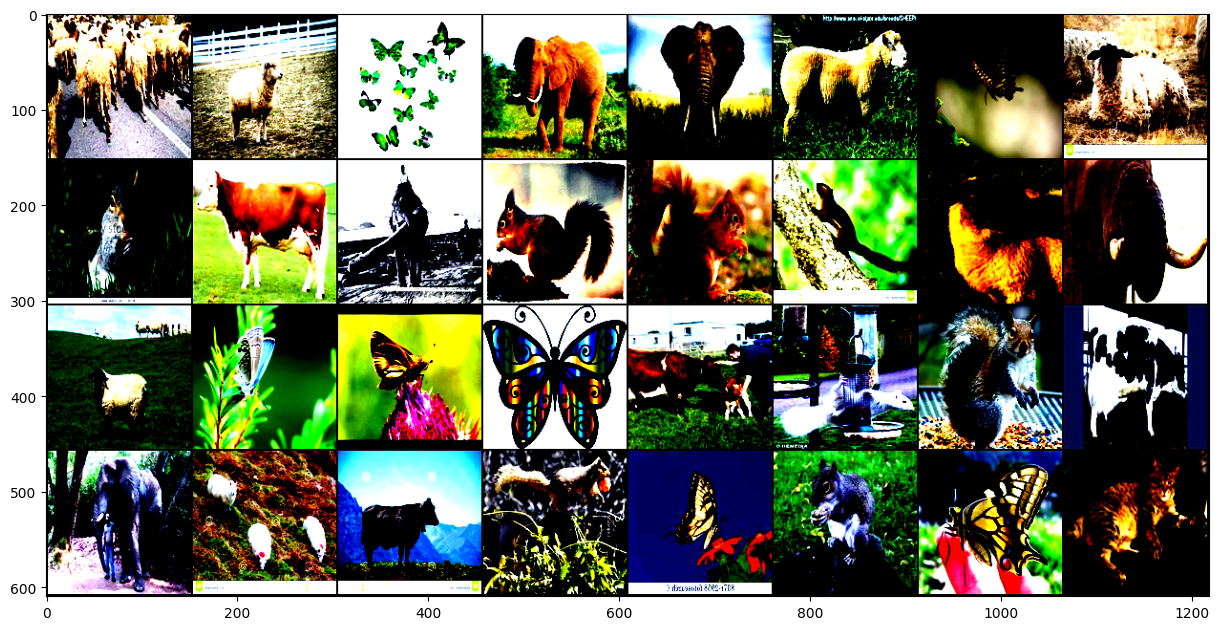

In [6]:
#visualize a batch of training data with labels
def show_batch(dataloader):
    images, labels = next(iter(dataloader))
    grid = torchvision.utils.make_grid(images, nrow=8)
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(grid, (1,2,0)))

show_batch(train_dataloader)

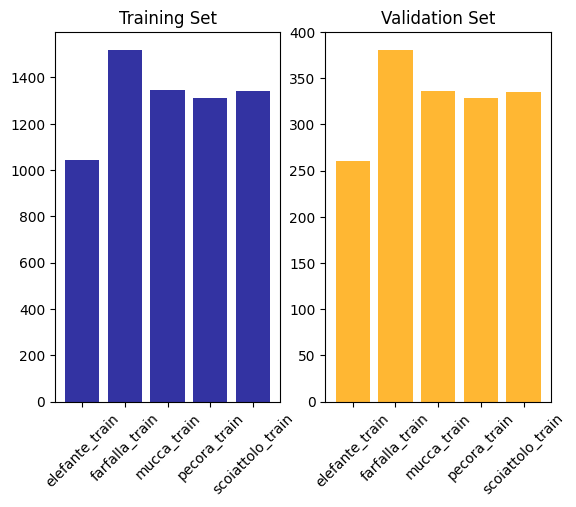

In [7]:
def fn_plot_label(tr_ds, ts_ds):

    plt.subplot(1,2,1)

    train_labels = np.concatenate([y for x, y in tr_ds], axis=0).squeeze()

    unique, counts = np.unique(train_labels, return_counts=True)

    plt.bar(range(len(unique)), counts, align='center',color = 'DarkBlue', alpha = 0.8)

    plt.title('Training Set')

    plt.xticks(range(len(unique)), class_names, rotation=45);


    plt.subplot(1,2,2)

    val_labels = np.concatenate([y for x, y in ts_ds], axis=0).squeeze()

    unique, counts = np.unique(val_labels, return_counts=True)

    plt.bar(range(len(unique)), counts, align='center', color = 'Orange', alpha = 0.8)

    plt.title('Validation Set')

    plt.xticks(range(len(unique)), class_names, rotation=45);

fn_plot_label(train_dataloader, val_dataloader)

In [8]:
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 9 * 9, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        logits = self.classifier(x)
        return logits

In [9]:
def get_nb_trainable_parameters(model):
    r"""
    Returns the number of trainable parameters and number of all parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        num_params = param.numel()
        # if using DS Zero 3 and the weights are initialized empty
        if num_params == 0 and hasattr(param, "ds_numel"):
            num_params = param.ds_numel

        # Due to the design of 4bit linear layers from bitsandbytes
        # one needs to multiply the number of parameters by 2 to get
        # the correct number of parameters
        if param.__class__.__name__ == "Params4bit":
            num_params = num_params * 2

        all_param += num_params
        if param.requires_grad:
            trainable_params += num_params

    return trainable_params, all_param



def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params, all_param = get_nb_trainable_parameters(model)

    print(
        f"trainable params: {trainable_params:,d} || all params: {all_param:,d} || trainable%: {100 * trainable_params / all_param}"
    )

In [10]:
def get_model(num_classes):
    torch.manual_seed(42)
    model = MyModel(num_classes)
    print_trainable_parameters(model)
    return model

In [11]:
model = get_model(len(class_names))
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names))

trainable params: 2,678,565 || all params: 2,678,565 || trainable%: 100.0


In [12]:
def train_one_epoch(model, loss_fn, optimizer, dataloader, device):
    model.train()
    losses = []
    accuracies = []
    for idx, (inputs, targets) in enumerate(dataloader):
        print(f"\rBatch {idx}/{len(dataloader)}", end="")
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accuracies.append(accuracy(outputs, targets).item())

    return np.mean(losses), np.mean(accuracies)

def validate_one_epoch(model, loss_fn, dataloader, device):
    model.eval()
    losses = []
    accuracies = []
    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(dataloader):
            print(f"\rBatch {idx}/{len(dataloader)}", end="")
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            loss = loss_fn(outputs, targets)

            losses.append(loss.item())
            accuracies.append(accuracy(outputs, targets).item())

    return np.mean(losses), np.mean(accuracies)

In [13]:
for i in range(config.epochs):
    print(f"Epoch {i+1}")
    train_loss, train_acc = train_one_epoch(model, loss, optimizer, train_dataloader, config.device)
    val_loss, val_acc = validate_one_epoch(model, loss, val_dataloader, config.device)
    print(f"\rTraining Loss: {train_loss:.5f}, Train Accuracy: {train_acc:.5f} | Validation Loss: {val_loss:.5f}, Validation Accuracy: {val_acc:.5f}")
    print("=====================================================================================================")

Epoch 1
Training Loss: 1.14921, Train Accuracy: 0.53643 | Validation Loss: 1.00798, Val Accuracy: 0.61779
Epoch 2
Training Loss: 0.84988, Train Accuracy: 0.67284 | Validation Loss: 0.81792, Val Accuracy: 0.67969
Epoch 3
Training Loss: 0.72366, Train Accuracy: 0.72467 | Validation Loss: 0.82597, Val Accuracy: 0.68329
Epoch 4
Training Loss: 0.62301, Train Accuracy: 0.76241 | Validation Loss: 0.71439, Val Accuracy: 0.74159
Epoch 5
Training Loss: 0.56260, Train Accuracy: 0.78968 | Validation Loss: 0.68881, Val Accuracy: 0.75962
Epoch 6
Training Loss: 0.45951, Train Accuracy: 0.83223 | Validation Loss: 0.73102, Val Accuracy: 0.74519
Epoch 7
Training Loss: 0.40445, Train Accuracy: 0.85135 | Validation Loss: 0.69546, Val Accuracy: 0.75120
Epoch 8
Training Loss: 0.32207, Train Accuracy: 0.88125 | Validation Loss: 0.70199, Val Accuracy: 0.76562
Epoch 9
Training Loss: 0.26581, Train Accuracy: 0.90270 | Validation Loss: 0.73841, Val Accuracy: 0.77704
Epoch 10
Training Loss: 0.23425, Train Accurac

In [ ]:
# save model
torch.save(model.state_dict(), 'model.pth')

In [ ]:
#Evaluation on validation set using classification accuracy and confusion matrix
def evaluate(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(dataloader):
            print(f"\rBatch {idx}/{len(dataloader)}", end="")
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    print()
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Accuracy:")
    print(accuracy_score(y_true, y_pred))

In [ ]:
#get path of all the images in data/validation folder using pathlib
from pathlib import Path
from PIL import Image
path = Path('data/validation')
files = path.glob('**/*.jp*g')

#convert to list
files = list(files)

validation_transform = transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # these are the means for the three channels of the images
                            std=[0.229, 0.224, 0.225])  # these are the standard deviations for the three channels of the images
])

# make predictions on all the files
model.eval()
y_pred = []
with torch.no_grad():
    for file in files:
        img = Image.open(file)
        img = validation_transform(img)
        img = img.unsqueeze(0)
        img = img.to(config.device)
        output = model(img)
        _, pred = torch.max(output, dim=1)
        y_pred.append(pred.item())